<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA9_SurvivalAndMissingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Cancer and Leukemia Group B dataset

Study CALGB 8541 (Example 11.1 from RLO)

The Cancer and Leukemia Group B (CALGB) conducted a randomized clinical trial to compare the benefits of three dose regimen intensities (high, moderate, and low) of a three-drug combination to treat non-metastatic breast cancer. The study, CALGB 8541, randomized over 1,500 women to one of the three treatment regimens.

The data set contains several variables: `seqno, study, arm, er, pgr, npn, tsizecm, premeno, survyrs, survstat, dfsyr`, and `dfsstat`.

----------------------

`survyrs` and `survstat`, respectively, contain the survival time in years and its censoring status (0 if uncensored time of death, 1 if right censored).
 Note that in the notation of Sections 11.1.2 and 11.1.3, this variable represents $\delta_1$ and not $\delta$ itself.

----------------------

The variables `dfsyrs` and `dfsstat` are similar, except they refer to disease-free survival. This means

if `dfsstat`=0, then `dfsyrs` is the time at which either death or disease relapse or recurrence occurred;

if `dfsstat`=1, then dfsyrs is the time at which the patient was last known to be alive without relapse or recurrence of disease (but the patient’s disease or survival status is not available beyond this point).


There are 519, 517, and 513 subjects in arms 1, 2, and 3, respectively.
Of these, right censored observations number 265, 231, and 244 for the survival outcome and 224, 188, and 197 for disease-free survival. The maximum follow-up time is about 20 years in each arm.

## Focus only on arm 1, we consider a parametric model

Let $T$ denote the dime of death (`survyrs`). The joint likelihood can be derived by assuming

$$
    T_1, \ldots, T_n \mid f \sim f(t)
$$
For the moment $f$ is a generic density function

When observations are censored, evaluation of the likelihood is impossible (of course).
Let $C_i$ denote the random censoring time of observation $i$, we assume that

1. Censoring is independent of the event of interest

2. $P(C \leq c)$ does not depend on the $\theta$ [non-informative censoring]

Hence

$$
    T_i, C_i \mid f, g \sim f(t) g(c)
$$

We rewrite the model in terms of $(y_i, \delta_i)$ such that $\delta = 0$ iff $Y=C$ and $\delta = 1$ iff $Y=T$.

We introduce the hazard and survival functions: $f(t) = h(t) S(t)$ and write the likelihood as

$$
    L\left(\{y_i, \delta_i\} \right) \propto \prod f(y_i)^{\delta_i} S(y_i)^{1 - \delta_i}
$$

In [1]:
!pip list | grep cmdstanpy
!pip list | grep arviz
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

cmdstanpy                          1.2.5
arviz                              0.20.0
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpi_dc8xu0
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [2]:
# Required modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Required functions
from cmdstanpy import CmdStanModel
from scipy.optimize import minimize
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [3]:
df = pd.read_csv("CALGB8541.csv")
df = df[df["arm"] == 1]
df = df.sample(frac=1)
y = df.survyrs
delta = (1 - df.survstat).astype(int)

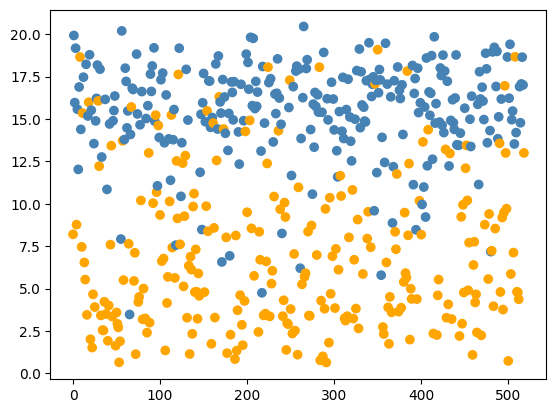

In [4]:
cols = np.array(["steelblue", "orange"])
plt.scatter(np.arange(len(y)), y, color=cols[delta])
plt.show()

For **prior elicitation**, we can use some statistics about Breast cancer available [here](https://www.cancer.net/cancer-types/breast-cancer/statistics). From this page, we get the following information:
- 5 years survival:  90%
- 10 years survival: 84%

## Exponential model

$$
    f(t | \theta) = \theta e^{- \theta t}
$$
$$
    \theta \sim \text{Gamma}(a, b)
$$

The quantile function of the exponential is
$$
    t_{p} = \frac{-log(1-p)}{\theta}
$$

we solve for $t_{0.1} = 5$ and $t_{0.16} = 10$ setting $\theta = \hat \theta = a/b$

In [5]:
b = - 5 / np.log(0.9)
a = 0.5 * np.log(0.84) / np.log(0.9)
print(a, b)

0.8274133153970885 47.45610790514952


In [6]:
def get_exp_posterior(y, delta, a, b):
    return np.sum(delta) + a, np.sum(y) + b

post_params = get_exp_posterior(y, delta, a, b)
post_samples = tfd.Gamma(post_params[0], post_params[1]).sample(100)

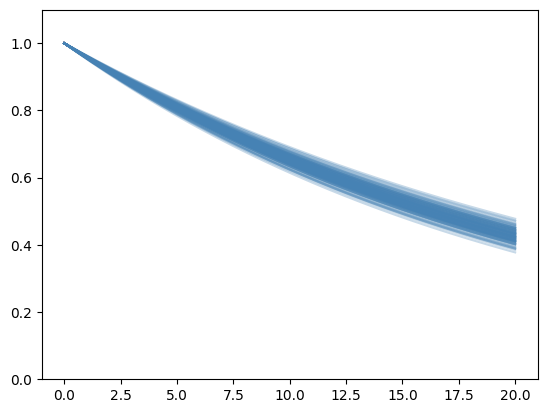

In [7]:
# plot the associated survival functions

t_range = np.linspace(0, 20, 1000)
surv = np.exp(- post_samples[:, np.newaxis] * t_range)
for i in range(len(post_samples)):
    plt.plot(t_range, surv[i, :], color='steelblue', alpha=0.3)

plt.ylim(0, 1.1)
plt.show()

# Weibull model

$$
T \sim Wieb(\alpha, \lambda) \iff T^{\alpha} \sim Exp(\lambda)
$$

$$
    f(t \mid \alpha, \lambda) = \lambda \alpha t^{\alpha -1} \exp \left( - \lambda t^\alpha \right) \mathbb{I}[t > 0]
$$

How to set priors for $\alpha$ and $\lambda$?

First, we set good guesses: for the Weibull distribution we know

$$
    1-q = P(T > t_q) = \exp(-\lambda t_q^\alpha)
$$

and we know that $P(T > 5) = 0.9$, $P(T > 10) = 0.84$ from previous studies.

So that we solve

$$
    \begin{cases}
    0.9 = \exp(-\lambda 5^\alpha) \\
    0.84 = \exp(-\lambda 10^\alpha)
    \end{cases}
$$

In [8]:
def obj_func(x):
    lamb = np.exp(x[1])
    alpha = np.exp(x[0])
    return (np.log(0.9) + lamb * 5 ** alpha)**2 + \
        (np.log(0.84) + lamb * 10 ** alpha)**2


out = minimize(obj_func, np.array([1, -11]))
vals = np.exp(out.x)
vals

array([0.72707927, 0.03268808])

In [9]:
# We compute the expected value for these parameters

from scipy.special import gamma

1.0 / vals[1] * gamma(1 + 1.0 / vals[0])

37.40025660127235

They make sense, so let's center priors around these.

## Watch out!

Stan uses a different parametrization

$$
    f(t \mid \alpha, \sigma) =  \frac{\alpha}{\sigma} \left( \frac{t}{\sigma} \right)^{\alpha -1} \exp \left( - \frac{t^\alpha}{\sigma} \right) \mathbb{I}[t > 0]
$$

So that $\sigma = (1/\lambda)^{\alpha}$

In [10]:
def obj_func(x):
    alpha = np.exp(x[0])
    sigma = np.exp(x[1])
    return (np.log(0.9) + (5 / sigma) ** alpha)**2 + \
        (np.log(0.84) + (10 / sigma)  ** alpha)**2

out = minimize(obj_func, np.array([-1, -1]))
vals = np.exp(out.x)
vals

array([  0.72667573, 110.63462953])

Given that $\sigma$ is very far from 0, a log-Normal or a Gamma one make little difference.
While for $\alpha$ that is pretty close to 0, a log-Normal is usually better.

The median of the log-normal distributin is $\exp(\mu)$, so we set

$$
    \alpha \sim \log N(\log 0.726, s_1^2)
$$

$$
    \sigma \sim \log N(\log 110.63, s_2^2)
$$

To set $s_1^2$ and $s_2^2$ observe that the mode of a log-normal is $\exp(\mu_j - s_j^2)$ so that large values of $s_j^2$ force the mode near to zero.

We set $s_1 = 1.0$ and $s_2 = 10$.

In [11]:
weib_censored = """
data {
    int<lower=0> n_obs;
    int<lower=0> n_cens;
    array[n_obs] real y_obs;
    array[n_cens] real y_cens;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
}

model {
    y_obs ~ weibull(alpha, sigma);
    for (i in 1:n_cens)
        target += weibull_lccdf(y_cens[i] | alpha, sigma);

    alpha ~ lognormal(-0.3202, 1.0);
    sigma ~ lognormal(4.70, 10.0);
}
"""

# Write stan model to file
stan_file = "./stan/weib_censored.stan"
with open(stan_file, "w") as f:
    print(weib_censored, file=f)

# Compile stan model
weib_censored = CmdStanModel(stan_file=stan_file)

23:15:42 - cmdstanpy - INFO - compiling stan file /content/stan/weib_censored.stan to exe file /content/stan/weib_censored
INFO:cmdstanpy:compiling stan file /content/stan/weib_censored.stan to exe file /content/stan/weib_censored
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=weib_censored.stan /content/stan/weib_censored
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=weib_censored.stan --o=/content/stan/weib_censored.hpp /content/stan/weib_censored.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.

In [12]:
y_obs = y[delta == 1]
y_cens = y[delta == 0]

In [13]:
len(y_obs)

254

In [14]:
len(y_cens)

265

In [15]:
# Data dictionary for stan
weib_data = {
    "n_obs": len(y_obs),
    "n_cens": len(y_cens),
    "y_obs": y_obs,
    "y_cens": y_cens
}

# MCMC run
weib_censored_fit = weib_censored.sample(data=weib_data, chains=4, parallel_chains=4,
                                         iter_warmup=1000, iter_sampling=5000)

DEBUG:cmdstanpy:cmd: /content/stan/weib_censored info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcrv9mel/h7c4rdao.json
23:16:01 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_censored', 'id=1', 'random', 'seed=51399', 'data', 'file=/tmp/tmpgcrv9mel/h7c4rdao.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_censoredrtdc9z53/weib_censored-20250208231601_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_censored', 'id=2', 'random', 'seed=51399', 'data', 'file=/tmp/tmpgcrv9mel/h7c4rdao.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_censoredrtdc9z53/weib_censored-20250208231601_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_censored', 'id=3', 'random', 'seed=51399', 'data', 'file=/tmp/tmpgcrv9mel/h7c4rdao.

23:16:07 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/weib_censored', 'id=1', 'random', 'seed=51399', 'data', 'file=/tmp/tmpgcrv9mel/h7c4rdao.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_censoredrtdc9z53/weib_censored-20250208231601_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpgcrv9mel/weib_censoredrtdc9z53/weib_censored-20250208231601_1.csv
 console_msgs (if any):
	/tmp/tmpgcrv9mel/weib_censoredrtdc9z53/weib_censored-20250208231601_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Defau

In [16]:
weib_censored_data = az.from_cmdstanpy(weib_censored_fit)

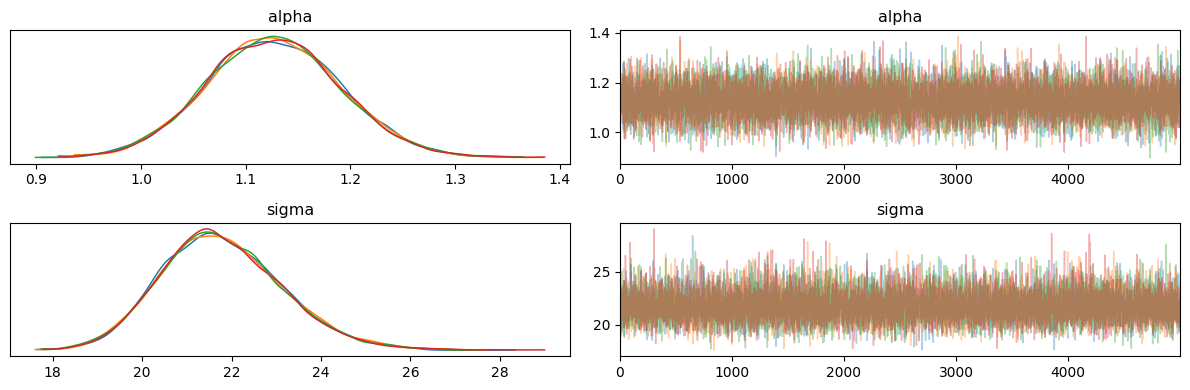

In [17]:
az.plot_trace(weib_censored_data, var_names=["alpha", "sigma"], compact=False)
plt.tight_layout()
plt.show()

(0.0, 1.1)

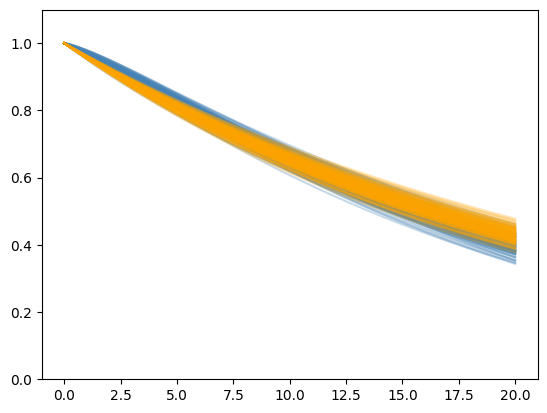

In [18]:
# plot some survival functions
alphas = np.ravel(weib_censored_data.posterior.alpha.values)
sigmas = np.ravel(weib_censored_data.posterior.sigma.values)

t_range = np.linspace(0, 20, 1000)

for i in range(100):
    plt.plot(t_range, np.exp(- (t_range / sigmas[i])**alphas[i] ), color='steelblue', alpha = 0.3)

surv = np.exp(- post_samples[:, np.newaxis] * t_range)
for i in range(len(post_samples)):
    plt.plot(t_range, surv[i, :], color='orange', alpha=0.3)

plt.ylim(0, 1.1)

# Let's take it Hierarchical

We consider the same dataset as before, but take into account different arms

$j$: study arm. $i$: patient's index (inside the arm)

\begin{equation*}
    \begin{aligned}
        L\left( \{y_{j, i}, \delta_{j, i}\}_{j, i} \mid \theta_1, \ldots, \theta_J \right) &= \prod f(y_{j, i} \mid \theta_j)^{\delta_{j, i}} S(y_{j, i})^{1 - \delta_{j, i}} \\
        \theta_j &= (\alpha_j, \sigma_j) \\
        \alpha_1, \ldots, \alpha_J \mid \alpha_0 &\sim \log N(\alpha_0, 1.0) \\
        \sigma_1, \ldots, \sigma_J \mid \sigma_0 &\sim \log N(\sigma_0, 10.0) \\
        \alpha_0 & \sim \log N(\log 0.726, 1.0) \\
        \sigma_0 & \sim \log N(\log 110.63, 10.0)
    \end{aligned}
\end{equation*}

where $f$ and $S$ represent the cdf and survival function of a Weibull distribution, respectively.

In [19]:
weib_hier = """
data {
    int<lower=0> n_groups;
    int<lower=0> n_tot;
    array[n_tot] real y;
    array[n_tot] int<lower=0, upper=n_groups> idx2group;
    array[n_tot] int<lower=0, upper=1> observed;
}

parameters {
    array[n_groups] real<lower=0> alpha;
    array[n_groups] real<lower=0> sigma;
    real<lower=0> alpha0;
    real<lower=0> sigma0;
}


model {
    for (i in 1:n_tot) {
        if (observed[i] == 1) {
            y[i] ~ weibull(alpha[idx2group[i]], sigma[idx2group[i]]);
        } else {
            target += weibull_lccdf(
                y[i] | alpha[idx2group[i]], sigma[idx2group[i]]);
        }
    }

    alpha ~ lognormal(alpha0, 1.0);
    sigma ~ lognormal(sigma0, 10.0);

    alpha0 ~ lognormal(-0.3202, 1.0);
    sigma0 ~ lognormal(4.70, 10.0);
}
"""

# Write stan model to file
stan_file = "./stan/weib_hier.stan"
with open(stan_file, "w") as f:
    print(weib_hier, file=f)

# Compile stan model
weib_hier = CmdStanModel(stan_file=stan_file)

23:16:30 - cmdstanpy - INFO - compiling stan file /content/stan/weib_hier.stan to exe file /content/stan/weib_hier
INFO:cmdstanpy:compiling stan file /content/stan/weib_hier.stan to exe file /content/stan/weib_hier
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=weib_hier.stan /content/stan/weib_hier
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=weib_hier.stan --o=/content/stan/weib_hier.hpp /content/stan/weib_hier.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_

In [20]:
df = pd.read_csv("CALGB8541.csv")
y = df.survyrs.values
delta = 1 - df.survstat.values
arm = df.arm.values

# Data dictionary for stan
weib_hier_data = {
    "n_groups": len(np.unique(arm)),
    "n_tot": len(y),
    "y": y,
    "idx2group": arm,
    "observed": delta
}

# MCMC run
weib_hier_fit = weib_hier.sample(data=weib_hier_data, chains=4, parallel_chains=4,
                                 iter_warmup=1000, iter_sampling=5000)

DEBUG:cmdstanpy:cmd: /content/stan/weib_hier info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcrv9mel/zv0zwp82.json
23:16:46 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_hier', 'id=1', 'random', 'seed=60306', 'data', 'file=/tmp/tmpgcrv9mel/zv0zwp82.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_hier', 'id=2', 'random', 'seed=60306', 'data', 'file=/tmp/tmpgcrv9mel/zv0zwp82.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_hier', 'id=3', 'random', 'seed=60306', 'data', 'file=/tmp/tmpgcrv9mel/zv0zwp82.json', 'output', 'file=/tmp/

23:17:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/weib_hier', 'id=1', 'random', 'seed=60306', 'data', 'file=/tmp/tmpgcrv9mel/zv0zwp82.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_1.csv
 console_msgs (if any):
	/tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Defau

In [21]:
weib_hier_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpgcrv9mel/stansummary-weib_hier-q1s05rhj.csv /tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_1.csv /tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_2.csv /tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_3.csv /tmp/tmpgcrv9mel/weib_hierl7av3f5g/weib_hier-20250208231646_4.csv
cwd: None


Mean      MCSE    StdDev       MAD            5%  \
lp__     -3267.540000  0.023182  1.987950  1.838420 -3.271230e+03   
alpha[1]     1.129120  0.000641  0.063703  0.063848  1.027400e+00   
alpha[2]     0.999904  0.000517  0.052830  0.052943  9.138990e-01   
alpha[3]     1.119030  0.000597  0.061620  0.061758  1.018890e+00   
sigma[1]    21.750000  0.013842  1.348070  1.328260  1.968590e+01   
sigma[2]    18.527400  0.011217  1.168160  1.138490  1.673120e+01   
sigma[3]    20.165600  0.011569  1.181580  1.175920  1.834300e+01   
alpha0       0.442910  0.002570  0.281055  0.255259  1.048990e-01   
sigma0       0.990131  0.019616  2.200230  0.044393  1.486620e-07   

                  50%          95%  ESS_bulk  ESS_tail    R_hat  
lp__     -3267.210000 -3264.920000   7416.37  10792.20  1.00019  
alpha[1]     1.128260     1.236510   9873.64  10374.20  1.00061  
alpha[2]     0.998895     1.088830  10460.00  10639.80  1.00023  
alpha[3]     1.117830     1.221700  10653.10  11272.30  1.00051  
sigma[1]    21.664300    24.077800   9668.26  10151.10  1.00037  
sigma[2]    18.475000    20.562000  11185.30  10388.20  1.00014  
sigma[3]    20.101300    22.218800  10677.20  10423.30  1.00054  
alpha0       0.381880     0.990649   9822.10   9391.56  1.00019  
sigma0       0.029943     5.974940   6070.03   6275.42  1.00024

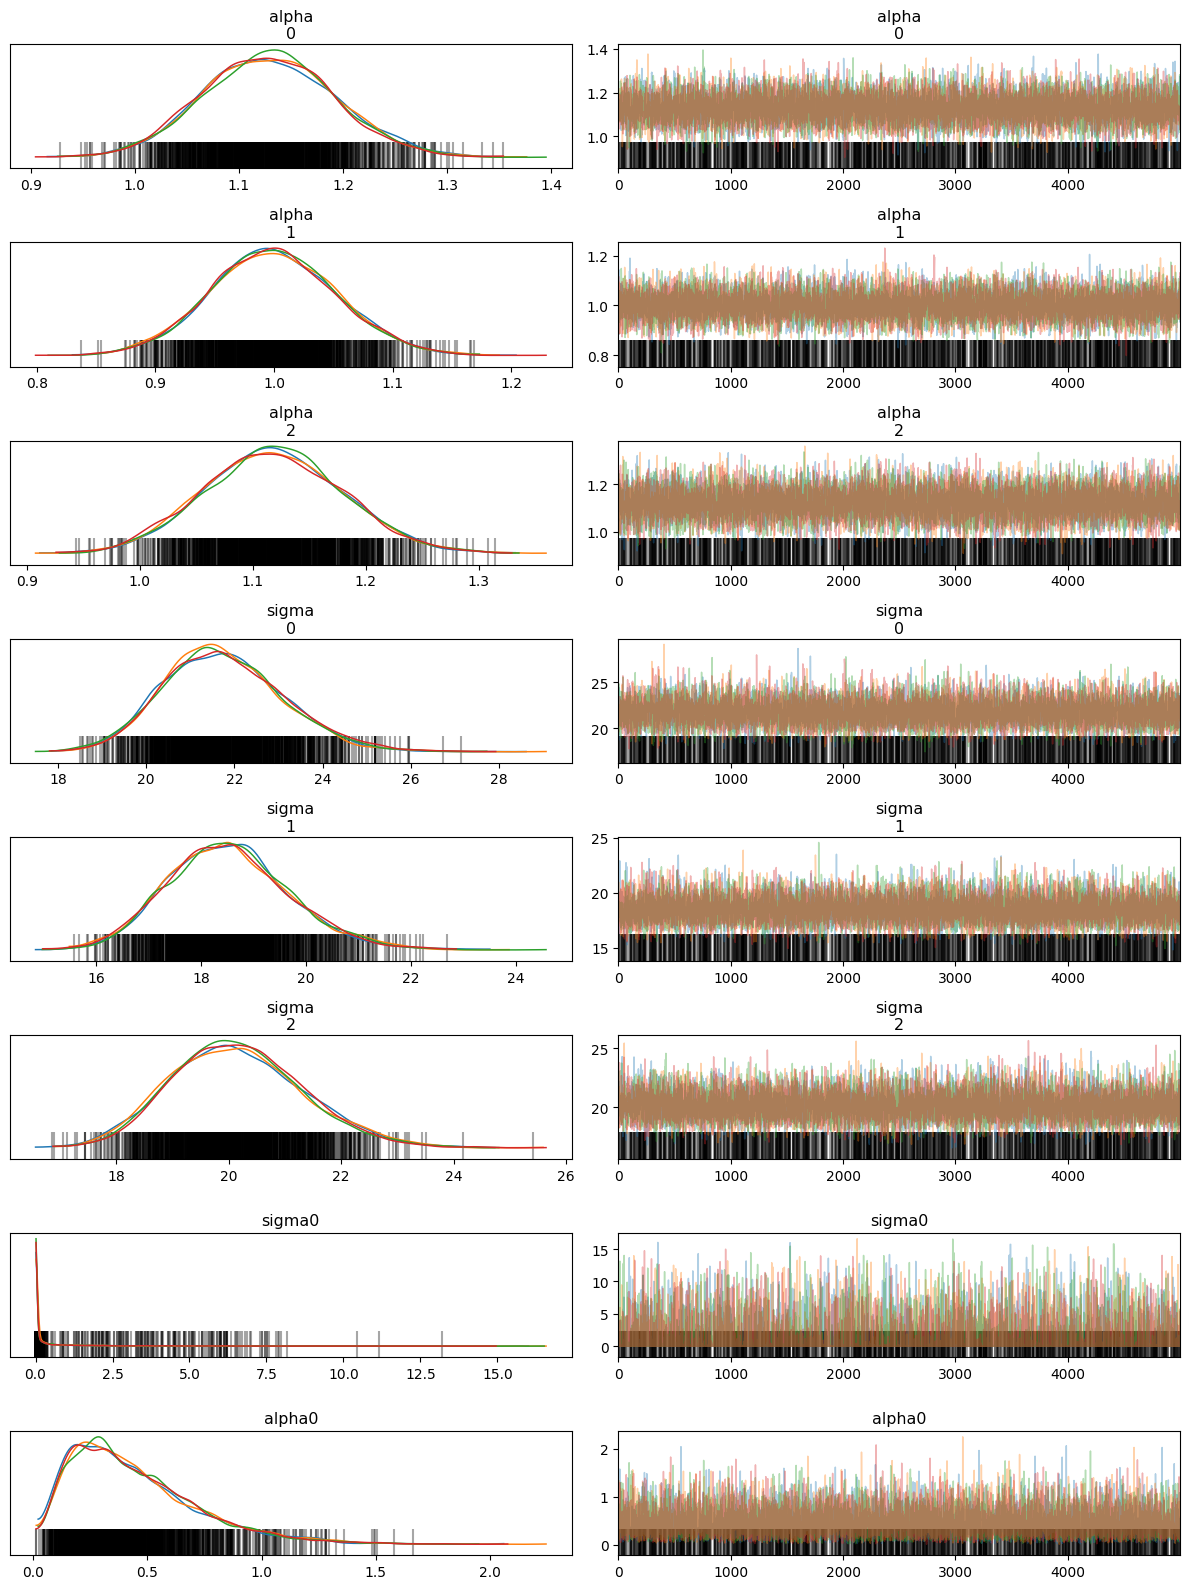

In [22]:
weib_hier_data = az.from_cmdstanpy(weib_hier_fit)
az.plot_trace(weib_hier_data, var_names=["alpha", "sigma", "sigma0", "alpha0"], compact=False)
plt.tight_layout()
plt.show()

In [23]:
def split_diverging(data, var_name):
    div_iters = np.where(data.sample_stats.diverging)
    non_div_iters = np.where(data.sample_stats.diverging == False)
    vals = data.posterior[var_name].values
    if len(vals.shape) == 2:
        vals = vals[:, :, np.newaxis]

    return (vals[div_iters[0], div_iters[1], :],
            vals[non_div_iters[0], non_div_iters[1], :])

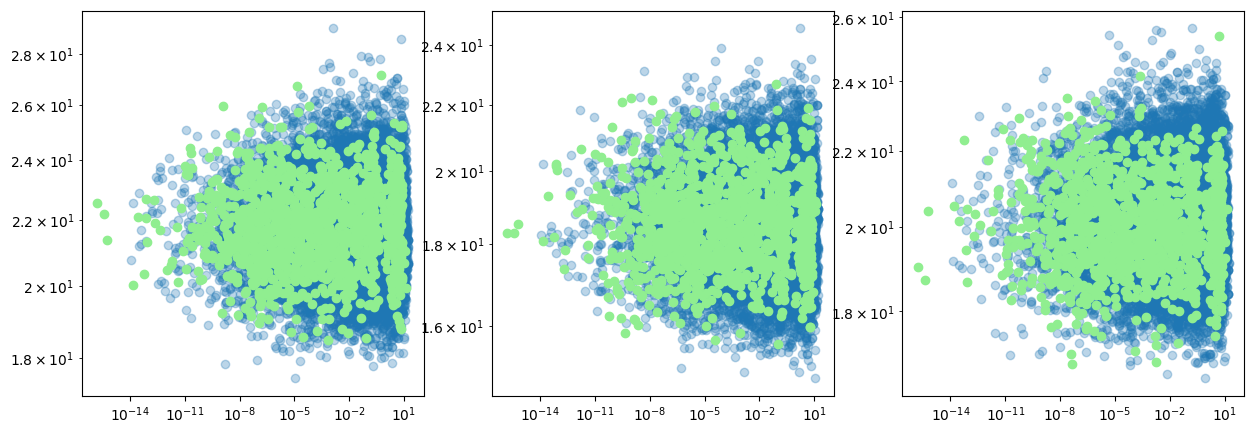

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sig0_div, sig0_nodiv = split_diverging(weib_hier_data, "sigma0")
sig_div, sig_nodiv = split_diverging(weib_hier_data, "sigma")

for i in range(3):
    axes[i].scatter(sig0_nodiv, sig_nodiv[:, i], alpha=0.3)
    axes[i].scatter(sig0_div, sig_div[:, i], color="lightgreen")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")

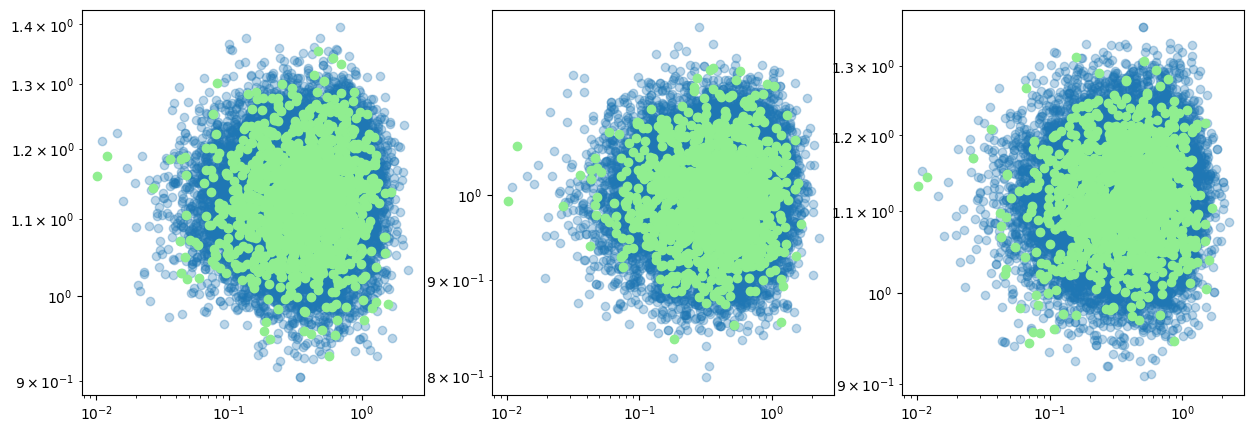

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

alpha0_div, alpha0_nodiv = split_diverging(weib_hier_data, "alpha0")
alpha_div, alpha_nodiv = split_diverging(weib_hier_data, "alpha")

for i in range(3):
    axes[i].scatter(alpha0_nodiv, alpha_nodiv[:, i], alpha=0.3)
    axes[i].scatter(alpha0_div, alpha_div[:, i], color="lightgreen")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")

**The problem may come come from $\sigma_0$ and/or $\alpha_0$, which take values that are too small**

Let us try to reduce the variances of $\sigma_0$ to $3^2$ and of $\alpha$'s and $\sigma$'s to $1.5^2$

In [26]:
weib_hier_reparam = """
data {
    int<lower=0> n_groups;
    int<lower=0> n_tot;
    array[n_tot] real y;
    array[n_tot] int<lower=0, upper=n_groups> idx2group;
    array[n_tot] int<lower=0, upper=1> observed;
}

parameters {
    array[n_groups] real alpha_raw;
    array[n_groups] real sigma_raw;
    real alpha0_raw;
    real sigma0_raw;
}

transformed parameters {
    real alpha0;
    real sigma0;
    array[n_groups] real<lower=0> alpha;
    array[n_groups] real<lower=0> sigma;

    alpha0 = exp(alpha0_raw * 1.0 - 0.3202);
    sigma0 = exp(sigma0_raw * 3.0 + 4.70);

    for (i in 1:n_groups) {
        alpha[i] = exp(alpha0 + 1.5 * alpha_raw[i]);
        sigma[i] = exp(sigma0 + 1.5 * sigma_raw[i]);
    }

}

model {
    for (i in 1:n_tot) {
        if (observed[i] == 1) {
            y[i] ~ weibull(alpha[idx2group[i]], sigma[idx2group[i]]);
        } else {
            target += weibull_lccdf(
                y[i] | alpha[idx2group[i]], sigma[idx2group[i]]);
        }
    }
    alpha_raw ~ normal(0.0, 1.0);
    sigma_raw ~ normal(0.0, 1.0);
    alpha0_raw ~ normal(0.0, 1.0);
    sigma0_raw ~ normal(0.0, 1.0);
}
"""

stan_file = "./stan/weib_hier_reparam.stan"

with open(stan_file, "w") as f:
    print(weib_hier_reparam, file=f)

weib_hier_reparam = CmdStanModel(stan_file=stan_file)

23:28:35 - cmdstanpy - INFO - compiling stan file /content/stan/weib_hier_reparam.stan to exe file /content/stan/weib_hier_reparam
INFO:cmdstanpy:compiling stan file /content/stan/weib_hier_reparam.stan to exe file /content/stan/weib_hier_reparam
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=weib_hier_reparam.stan /content/stan/weib_hier_reparam
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=weib_hier_reparam.stan --o=/content/stan/weib_hier_reparam.hpp /content/stan/weib_hier_reparam.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -

In [27]:
stan_data = {
    "n_groups": len(np.unique(arm)),
    "n_tot": len(y),
    "y": y,
    "idx2group": arm,
    "observed": delta
}

weib_hier_reparam_fit = weib_hier_reparam.sample(data=stan_data, chains=4, parallel_chains=4,
                                                 iter_warmup=1000, iter_sampling=1000)

DEBUG:cmdstanpy:cmd: /content/stan/weib_hier_reparam info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcrv9mel/mrtxb1pn.json
23:29:03 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_hier_reparam', 'id=1', 'random', 'seed=66619', 'data', 'file=/tmp/tmpgcrv9mel/mrtxb1pn.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_hier_reparam', 'id=3', 'random', 'seed=66619', 'data', 'file=/tmp/tmpgcrv9mel/mrtxb1pn.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_3.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/weib_hier_reparam', 'id=2', 'random', 'seed=66619', 'data', 'fil

23:31:16 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/weib_hier_reparam', 'id=1', 'random', 'seed=66619', 'data', 'file=/tmp/tmpgcrv9mel/mrtxb1pn.json', 'output', 'file=/tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_1.csv
 console_msgs (if any):
	/tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = tr

In [28]:
weib_hier_reparam_data = az.from_cmdstanpy(weib_hier_reparam_fit)

In [29]:
weib_hier_reparam_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpgcrv9mel/stansummary-weib_hier_reparam-qwawbjp5.csv /tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_1.csv /tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_2.csv /tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_3.csv /tmp/tmpgcrv9mel/weib_hier_reparammkhaujsy/weib_hier_reparam-20250208232903_4.csv
cwd: None


Mean      MCSE    StdDev       MAD           5%  \
lp__         -3260.510000  0.059246  1.979370  1.808770 -3264.190000   
alpha_raw[1]    -0.274814  0.009684  0.238479  0.209788    -0.746022   
alpha_raw[2]    -0.355678  0.009680  0.238050  0.203408    -0.826436   
alpha_raw[3]    -0.278888  0.009694  0.238049  0.205536    -0.744702   
sigma_raw[1]     0.163826  0.021687  0.599514  0.614693    -0.832737   
sigma_raw[2]     0.056523  0.021725  0.599661  0.622358    -0.944072   
sigma_raw[3]     0.112166  0.021747  0.599530  0.622372    -0.894296   
alpha0_raw      -0.540337  0.026965  0.711124  0.695167    -1.796140   
sigma0_raw      -1.239730  0.004438  0.125910  0.109082    -1.456160   
alpha0           0.530963  0.014488  0.354085  0.303938     0.120472   
sigma0           2.833520  0.032566  0.899263  0.927522     1.393080   
alpha[1]         1.127850  0.001022  0.063203  0.063581     1.026530   
alpha[2]         0.998793  0.000866  0.051827  0.052002     0.915705   
alpha[3]         1.120920  0.001022  0.061826  0.062091     1.020620   
sigma[1]        21.783900  0.021409  1.353550  1.301800    19.706000   
sigma[2]        18.543800  0.017876  1.124340  1.087560    16.795200   
sigma[3]        20.155600  0.018777  1.184190  1.176000    18.353400   

                      50%          95%  ESS_bulk  ESS_tail    R_hat  
lp__         -3260.180000 -3257.930000  1129.510  1709.530  1.00304  
alpha_raw[1]    -0.223758     0.010892   673.848   879.658  1.00419  
alpha_raw[2]    -0.302308    -0.074377   667.636   847.862  1.00365  
alpha_raw[3]    -0.226887     0.006617   662.506   820.887  1.00404  
sigma_raw[1]     0.186505     1.131000   763.580   724.614  1.01140  
sigma_raw[2]     0.084622     1.021830   760.856   782.665  1.01136  
sigma_raw[3]     0.144049     1.076930   758.718   761.721  1.01108  
alpha0_raw      -0.479329     0.530516   662.125   848.394  1.00416  
sigma0_raw      -1.224430    -1.077960   761.327   737.199  1.01103  
alpha0           0.449541     1.234070   662.124   848.394  1.00416  
sigma0           2.791830     4.332340   761.335   737.199  1.01103  
alpha[1]         1.128370     1.229770  3820.050  3213.640  1.00052  
alpha[2]         0.997290     1.085850  3604.950  3003.800  0.99991  
alpha[3]         1.119080     1.224630  3662.660  2906.460  1.00211  
sigma[1]        21.691700    24.130200  4028.440  3128.850  1.00145  
sigma[2]        18.498300    20.433600  3974.860  2970.490  1.00059  
sigma[3]        20.091700    22.217100  4111.880  3378.920  1.00025

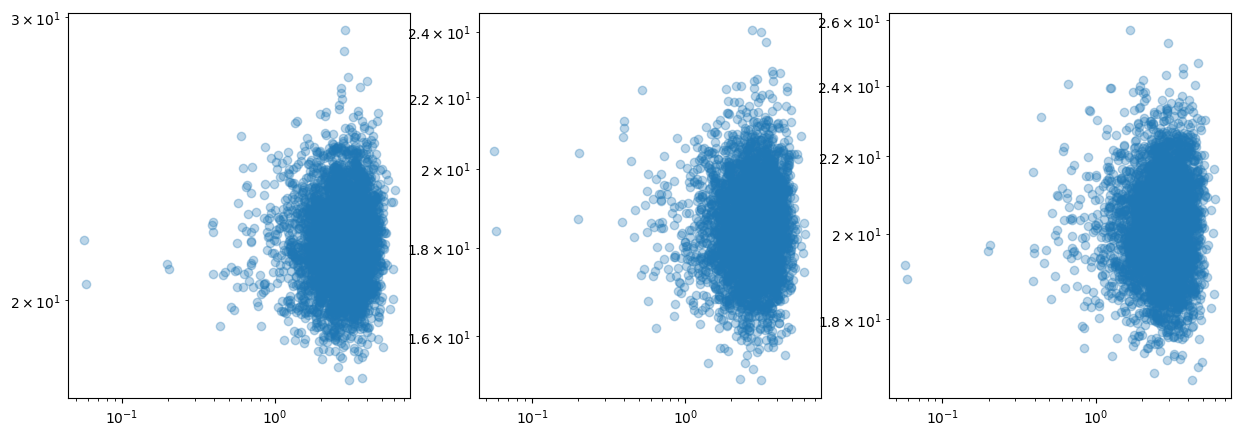

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sig0_div, sig0_nodiv = split_diverging(weib_hier_reparam_data, "sigma0")
sig_div, sig_nodiv = split_diverging(weib_hier_reparam_data, "sigma")

for i in range(3):
    axes[i].scatter(sig0_nodiv, sig_nodiv[:, i], alpha=0.3)
    axes[i].scatter(sig0_div, sig_div[:, i], color="lightgreen")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")

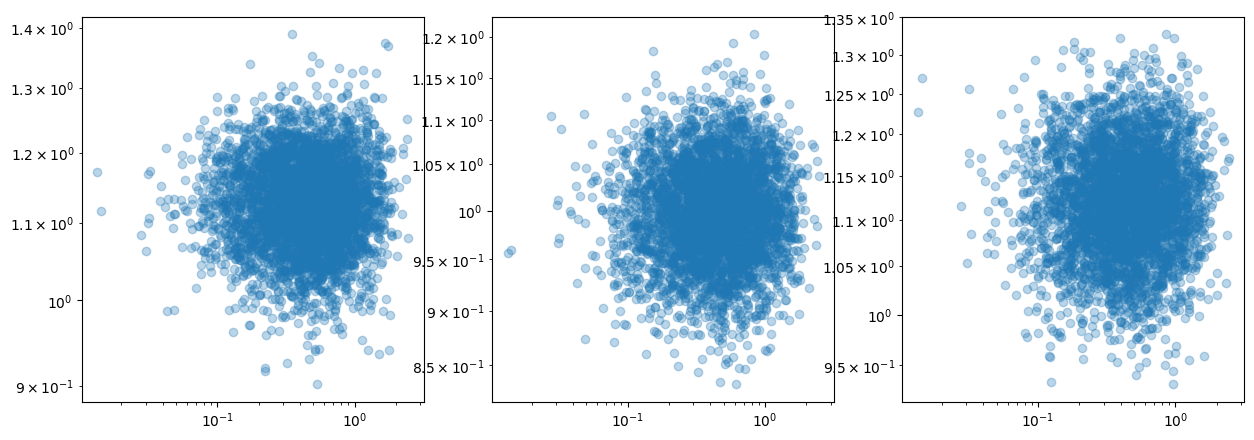

In [31]:
alpha0_div, alpha0_nodiv = split_diverging(weib_hier_reparam_data, "alpha0")
alpha_div, alpha_nodiv = split_diverging(weib_hier_reparam_data, "alpha")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i in range(3):
    axes[i].scatter(alpha0_nodiv, alpha_nodiv[:, i], alpha=0.3)
    axes[i].scatter(alpha0_div, alpha_div[:, i], color="lightgreen")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")

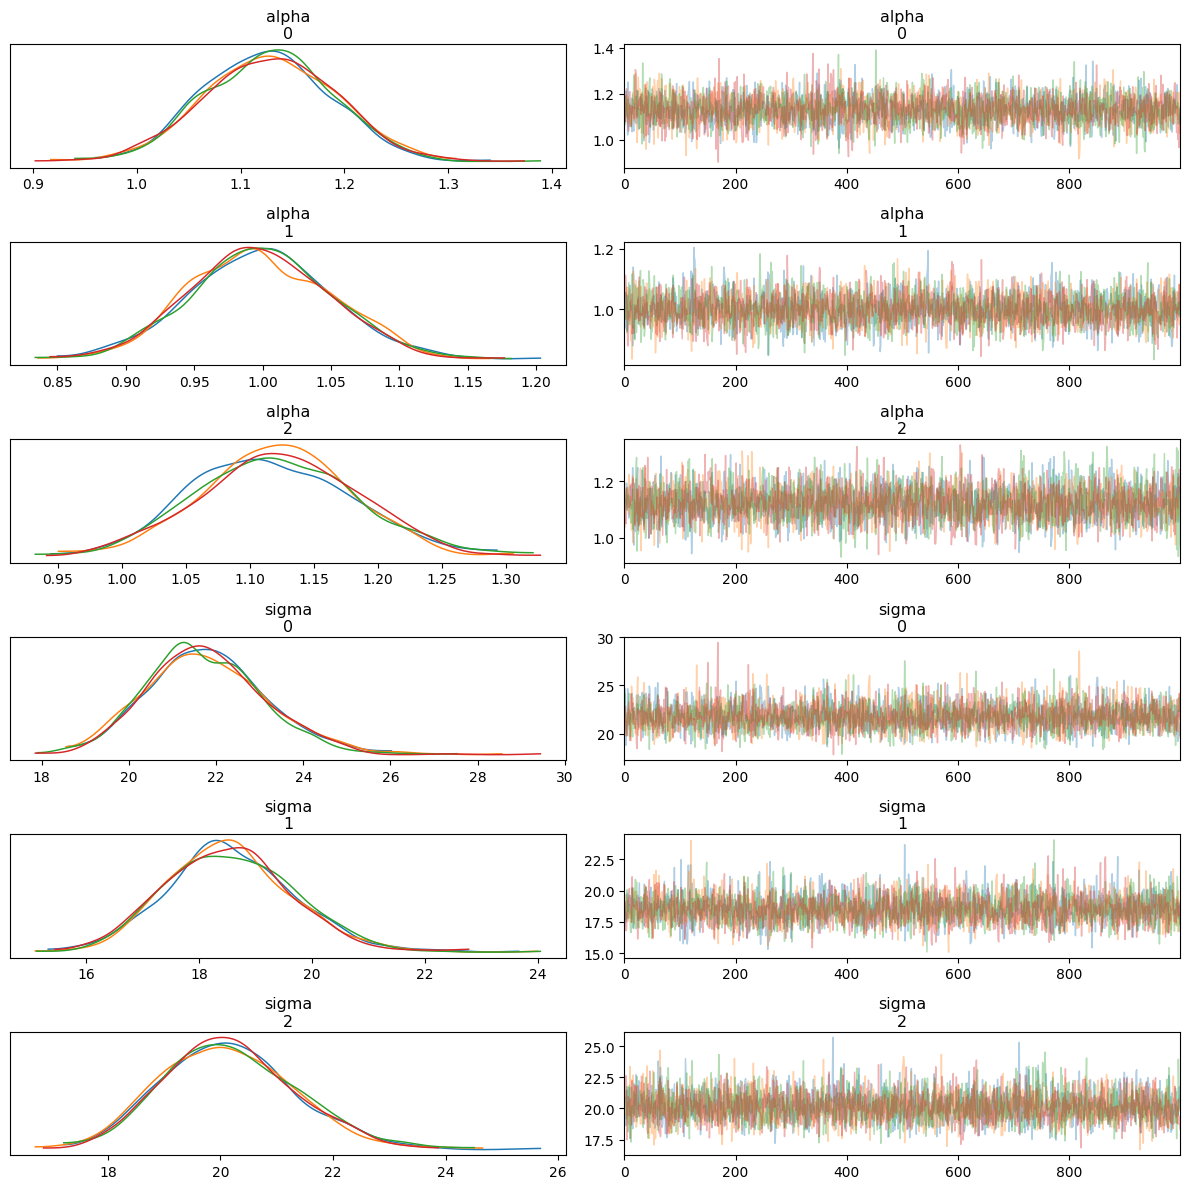

In [32]:
# weib_hier_data = az.from_cmdstanpy(weib_hier_fit)
az.plot_trace(weib_hier_reparam_data, var_names=["alpha", "sigma"], compact=False)
plt.tight_layout()
plt.show()

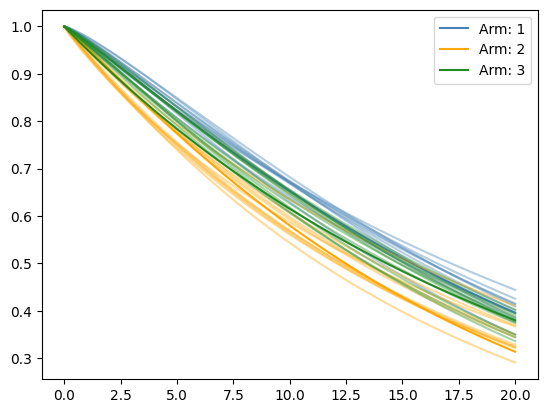

In [33]:
# plot some survival functions

t_range = np.linspace(0, 20, 1000)

cols = ["steelblue", "orange", "forestgreen"]

for i in range(3):
    alphas = np.ravel(weib_hier_data.posterior.alpha[:, :, i])
    sigmas = np.ravel(weib_hier_data.posterior.sigma[:, :, i])

    plt.plot(t_range, np.exp(- (t_range / sigmas[0])**alphas[0]),
                 color=cols[i], label="Arm: {0}".format(i+1))

    for j in range(10):
        idx = np.random.choice(len(alphas))
        plt.plot(t_range, np.exp(- (t_range / sigmas[idx])**alphas[idx]),
                 color=cols[i], alpha=0.4)
plt.legend()
plt.show()

# Handling Missing Data

Censored data are a very particular kind of missing data. But we can handle them also in more general cases

### Example 1: missing responses in a regression model
We generate a fictional dataset for this example...

In [34]:
n = 200
p = 100

X = np.random.normal(size=(n, p))
beta_true = np.random.normal(size=p)
y_true = X @ beta_true + np.random.normal(size=n)

In [35]:
y_true.shape

(200,)

... and then split observed and missing data

In [36]:
obs_mask = np.random.uniform(size=n) > 0.5
obs_idx = np.where(obs_mask)[0]

y_obs = y_true[obs_mask]
X_obs = X[obs_mask, :]
X_mis = X[~obs_mask, :]

We code and run the model **without** missing data

In [37]:
normal_reg = """
data {
  int<lower=1> n;
  int<lower=1> p;
  vector[n] y;
  matrix[n, p] X;
}

parameters {
  real<lower=0> tau;
  real<lower=0> sigma;
  vector[p] eta;
  real alpha;
}

transformed parameters {
  vector[p] beta = eta * tau;
  vector[n] mean = alpha + X * beta;
}

model {
  alpha ~ normal(0, 10);
  eta ~ normal(0, 1);
  sigma ~ normal(0, 10);
  tau ~ cauchy(0, 1);
  y ~ normal(mean, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n)
      log_lik[i] = normal_lpdf(y[i] | mean[i], sigma);
}
"""

# Print stan model to file
stan_file = "./stan/normal_reg.stan"
with open(stan_file, "w") as f:
    print(normal_reg, file=f)

# Compile stan model
normal_reg = CmdStanModel(stan_file=stan_file)

23:31:48 - cmdstanpy - INFO - compiling stan file /content/stan/normal_reg.stan to exe file /content/stan/normal_reg
INFO:cmdstanpy:compiling stan file /content/stan/normal_reg.stan to exe file /content/stan/normal_reg
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=normal_reg.stan /content/stan/normal_reg
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=normal_reg.stan --o=/content/stan/normal_reg.hpp /content/stan/normal_reg.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST

In [38]:
# Data dictionary for stan
normal_reg_data = {
    "n": len(y_obs),
    "p": X_obs.shape[1],
    "y": y_obs,
    "X": X_obs
}

# MCMC run
normal_reg_fit = normal_reg.sample(normal_reg_data, iter_sampling=5000)
normal_reg_az = az.from_cmdstanpy(normal_reg_fit)

DEBUG:cmdstanpy:cmd: /content/stan/normal_reg info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcrv9mel/xxama5re.json
23:32:11 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/normal_reg', 'id=1', 'random', 'seed=88657', 'data', 'file=/tmp/tmpgcrv9mel/xxama5re.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_regutwsss3l/normal_reg-20250208233211_1.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/normal_reg', 'id=2', 'random', 'seed=88657', 'data', 'file=/tmp/tmpgcrv9mel/xxama5re.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_regutwsss3l/normal_reg-20250208233211_2.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/normal_reg', 'id=3', 'random', 'seed=88657', 'data', 'file=/tmp/tmpgcrv9mel/xxama5re.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_regutwsss3l/

23:32:51 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/normal_reg', 'id=1', 'random', 'seed=88657', 'data', 'file=/tmp/tmpgcrv9mel/xxama5re.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_regutwsss3l/normal_reg-20250208233211_1.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpgcrv9mel/normal_regutwsss3l/normal_reg-20250208233211_1.csv
 console_msgs (if any):
	/tmp/tmpgcrv9mel/normal_regutwsss3l/normal_reg-20250208233211_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      ka

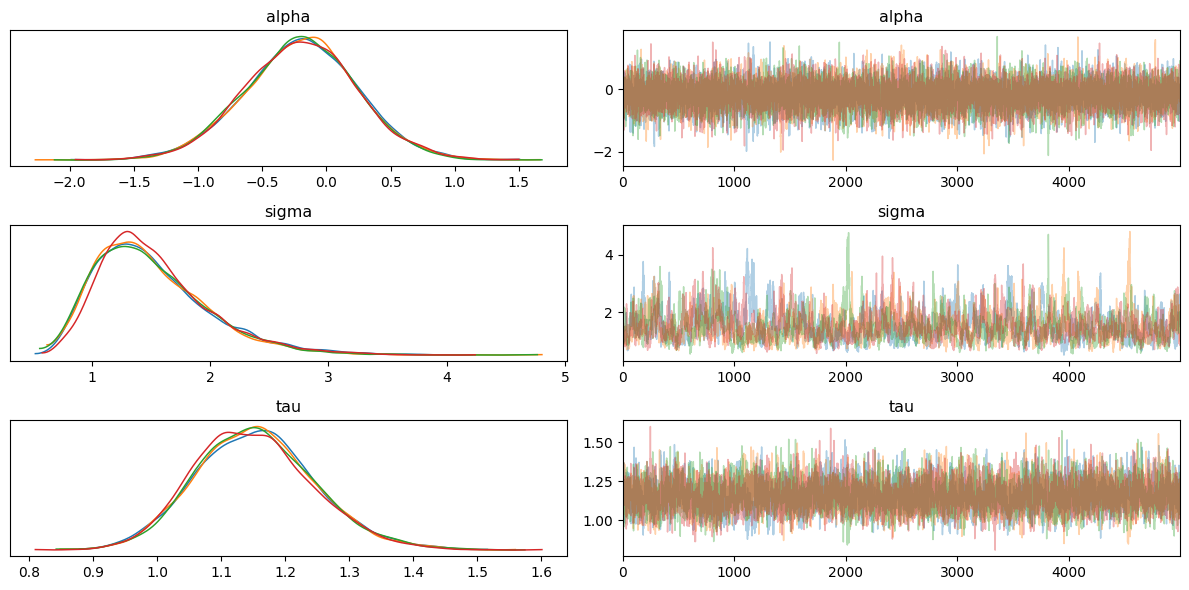

In [39]:
az.plot_trace(normal_reg_az, var_names=["alpha", "sigma", "tau"], compact=False)
plt.tight_layout()
plt.show()

And now the one in which we also impute the missing data

In [40]:
normal_reg_miss = """
data {
  int<lower=1> n_obs;
  int<lower=1> n_mis;
  int<lower=1> p;
  vector[n_obs] y_obs;
  matrix[n_obs, p] X_obs;
  matrix[n_mis, p] X_mis;
}

parameters {
  real<lower=0> tau;
  real<lower=0> sigma;
  vector[p] eta;
  real alpha;
  vector[n_mis] y_mis;
}

transformed parameters {
  vector[p] beta = eta * tau;
  vector[n_obs] mean_obs = alpha + X_obs * beta;
  vector[n_mis] mean_mis = alpha + X_mis * beta;
}

model {
  alpha ~ normal(0, 10);
  eta ~ normal(0, 1);
  sigma ~ normal(0, 10);
  tau ~ cauchy(0, 1);
  y_obs ~ normal(mean_obs, sigma);
  y_mis ~ normal(mean_mis, sigma);
}

generated quantities {
  vector[n_obs] log_lik;
  for (i in 1:n_obs)
      log_lik[i] = normal_lpdf(y_obs[i] | mean_obs[i], sigma);
}
"""

# Write stan model to file
stan_file = "./stan/normal_reg_miss.stan"
with open(stan_file, "w") as f:
    print(normal_reg_miss, file=f)

# Compile stan model
normal_reg_miss = CmdStanModel(stan_file=stan_file)

23:33:01 - cmdstanpy - INFO - compiling stan file /content/stan/normal_reg_miss.stan to exe file /content/stan/normal_reg_miss
INFO:cmdstanpy:compiling stan file /content/stan/normal_reg_miss.stan to exe file /content/stan/normal_reg_miss
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=normal_reg_miss.stan /content/stan/normal_reg_miss
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=normal_reg_miss.stan --o=/content/stan/normal_reg_miss.hpp /content/stan/normal_reg_miss.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_ma

In [41]:
# Data dictionary for stan
reg_data = {
    "n_obs": len(y_obs),
    "n_mis": X_mis.shape[0],
    "p": X_obs.shape[1],
    "y_obs": y_obs,
    "X_obs": X_obs,
    "X_mis": X_mis
}

# MCMC run
normal_reg_miss_fit = normal_reg_miss.sample(reg_data, iter_sampling=5000)
normal_reg_miss_az = az.from_cmdstanpy(normal_reg_miss_fit)

DEBUG:cmdstanpy:cmd: /content/stan/normal_reg_miss info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcrv9mel/v4qvkuvh.json
23:33:35 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/normal_reg_miss', 'id=1', 'random', 'seed=45434', 'data', 'file=/tmp/tmpgcrv9mel/v4qvkuvh.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_reg_miss190n4cv2/normal_reg_miss-20250208233335_1.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/normal_reg_miss', 'id=2', 'random', 'seed=45434', 'data', 'file=/tmp/tmpgcrv9mel/v4qvkuvh.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_reg_miss190n4cv2/normal_reg_miss-20250208233335_2.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/normal_reg_miss', 'id=3', 'random', 'seed=45434', 'data', 'file=/tmp/tmpgcrv9mel/v4qvkuvh.json', 'output', 'file=/

23:35:33 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/normal_reg_miss', 'id=1', 'random', 'seed=45434', 'data', 'file=/tmp/tmpgcrv9mel/v4qvkuvh.json', 'output', 'file=/tmp/tmpgcrv9mel/normal_reg_miss190n4cv2/normal_reg_miss-20250208233335_1.csv', 'method=sample', 'num_samples=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpgcrv9mel/normal_reg_miss190n4cv2/normal_reg_miss-20250208233335_1.csv
 console_msgs (if any):
	/tmp/tmpgcrv9mel/normal_reg_miss190n4cv2/normal_reg_miss-20250208233335_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
 

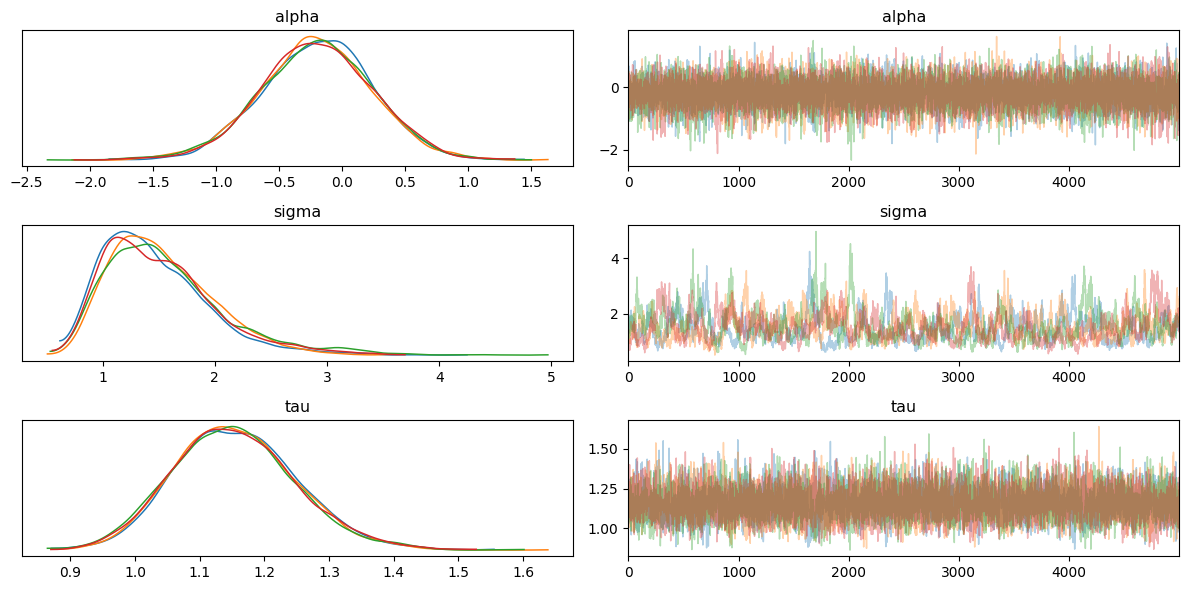

In [42]:
az.plot_trace(normal_reg_miss_az, var_names=["alpha", "sigma", "tau"], compact=False)
plt.tight_layout()
plt.show()

Finally, we can compare those models:

In [43]:
models = {
    "No Missing": normal_reg_az,
    "With Missing": normal_reg_miss_az
}
az.compare(models, var_name="log_lik")

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff  weight        se  \
With Missing     0 -245.828319  87.734093   0.000000     1.0  2.941823   
No Missing       1 -246.758139  88.276084   0.929821     0.0  3.398788   

                   dse  warning scale  
With Missing  0.000000     True   log  
No Missing    1.016627     True   log

## Example 2: missing data in time series models
We again create a fictional dataset. Now missing and observed data are related!

In [44]:
phi = np.array([-0.8, 0.35])
sig = 1.0

y_true = np.zeros(100)
y_true[0] = 3
y_true[1] = np.random.normal(phi[0] * y[0], sig)

for i in range(2, 100):
    y_true[i] = np.random.normal(np.dot(y_true[(i-2):i], phi), sig)

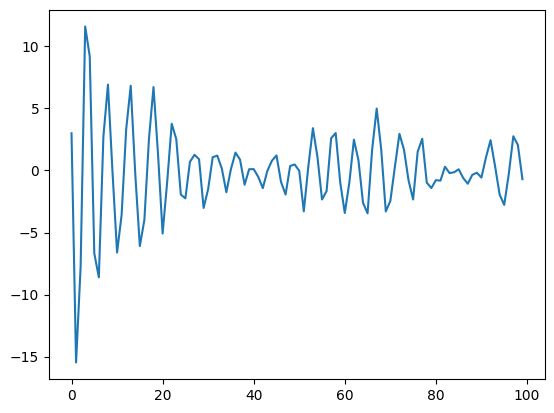

In [45]:
plt.plot(y_true)
plt.show()

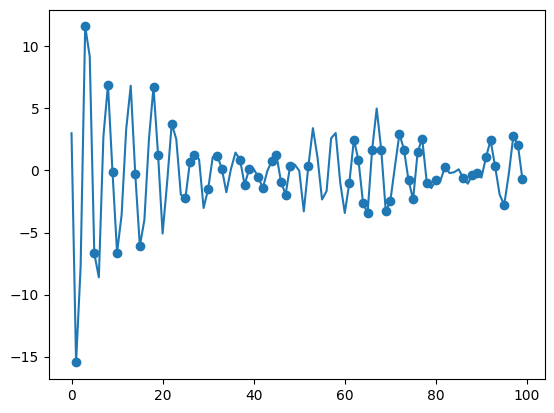

In [46]:
obs_mask = np.random.uniform(size=len(y_true)) > 0.5
obs_idx = np.where(obs_mask)[0]
miss_idx = np.where(~obs_mask)[0]

y_obs = y_true[obs_mask]
plt.scatter(obs_idx, y_obs)
plt.plot(y_true)
plt.show()

In [47]:
ts_miss = """
data {
    int<lower=1> n_obs;
    int<lower=1> n_mis;
    vector[n_obs] y_obs;
    array[n_obs] int observed_idx;
    array[n_mis] int missing_idx;
}

transformed data {
    int n_tot = n_obs + n_mis;
}

parameters {
    vector[n_mis] y_mis;
    vector[2] phi;
    real<lower=0> sigma;
}

transformed parameters {
    vector[n_tot] y;
    for (i in 1:n_obs) {
        y[observed_idx[i]] = y_obs[i];
    }
    for (i in 1:n_mis) {
        y[missing_idx[i]] = y_mis[i];
    }
}

model {
    for (i in 3:n_tot) {
        y[i] ~ normal(y[i-1] * phi[1] + y[i-2] * phi[2], sigma);
    }
    sigma ~ student_t(3, 0, 5);
    phi ~ normal(0, 1.5);
}
"""

# Write stan model to file
stan_file = "./stan/ts_miss.stan"
with open(stan_file, "w") as f:
    print(ts_miss, file=f)

# Compile stan model
ts_miss = CmdStanModel(stan_file=stan_file)

23:36:48 - cmdstanpy - INFO - compiling stan file /content/stan/ts_miss.stan to exe file /content/stan/ts_miss
INFO:cmdstanpy:compiling stan file /content/stan/ts_miss.stan to exe file /content/stan/ts_miss
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=ts_miss.stan /content/stan/ts_miss
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=ts_miss.stan --o=/content/stan/ts_miss.hpp /content/stan/ts_miss.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -

In [48]:
# Data dictionary for stan
ts_miss_data = {
    "n_obs": len(y_obs),
    "n_mis": len(miss_idx),
    "y_obs": y_obs,
    "observed_idx": obs_idx + 1,
    "missing_idx": miss_idx + 1
}

# MCMC run
ts_miss_fit = ts_miss.sample(ts_miss_data)
ts_miss_az = az.from_cmdstanpy(ts_miss_fit)

DEBUG:cmdstanpy:cmd: /content/stan/ts_miss info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcrv9mel/q4f47xon.json
23:37:08 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/ts_miss', 'id=1', 'random', 'seed=664', 'data', 'file=/tmp/tmpgcrv9mel/q4f47xon.json', 'output', 'file=/tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/ts_miss', 'id=2', 'random', 'seed=664', 'data', 'file=/tmp/tmpgcrv9mel/q4f47xon.json', 'output', 'file=/tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/ts_miss', 'id=3', 'random', 'seed=664', 'data', 'file=/tmp/tmpgcrv9mel/q4f47xon.json', 'output', 'file=/tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_3.csv', 'method=sample', 'algorithm=hmc', 'adap

23:37:11 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/ts_miss', 'id=1', 'random', 'seed=664', 'data', 'file=/tmp/tmpgcrv9mel/q4f47xon.json', 'output', 'file=/tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_1.csv
 console_msgs (if any):
	/tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75 (Default)
      t0 = 1

In [49]:
ts_miss_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpgcrv9mel/stansummary-ts_miss-iuuxmc7g.csv /tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_1.csv /tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_2.csv /tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_3.csv /tmp/tmpgcrv9mel/ts_misstq1pnwj_/ts_miss-20250208233708_4.csv
cwd: None


Mean      MCSE        StdDev      MAD         5%        50%  \
lp__     -50.204500  0.224294  6.970890e+00  6.84828 -62.407100 -49.781400   
y_mis[1]  -7.468070  0.064244  2.980550e+00  2.82508 -12.458200  -7.406890   
y_mis[2]  -0.964274  0.038813  1.803350e+00  1.70658  -3.874410  -0.992307   
y_mis[3]   5.743500  0.026785  1.298230e+00  1.25991   3.565740   5.728270   
y_mis[4]  -7.217740  0.019830  1.099610e+00  1.05778  -9.020600  -7.221190   
...             ...       ...           ...      ...        ...        ...   
y[96]     -2.772350       NaN  2.886940e-14  0.00000  -2.772350  -2.772350   
y[97]      0.063732  0.012265  8.392350e-01  0.81863  -1.306650   0.061351   
y[98]      2.757400       NaN  3.020180e-14  0.00000   2.757400   2.757400   
y[99]      2.056160       NaN  3.686400e-14  0.00000   2.056160   2.056160   
y[100]    -0.704628       NaN  4.330410e-15  0.00000  -0.704628  -0.704628   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__     -39.861300   965.571   1926.02  1.001080  
y_mis[1]  -2.739570  2212.800   2708.45  1.000680  
y_mis[2]   2.016690  2254.980   2597.99  1.001720  
y_mis[3]   7.869060  2371.400   2782.61  1.002000  
y_mis[4]  -5.334020  3099.440   2852.99  1.001150  
...             ...       ...       ...       ...  
y[96]     -2.772350       NaN       NaN       NaN  
y[97]      1.454020  4762.360   2947.45  0.999925  
y[98]      2.757400       NaN       NaN       NaN  
y[99]      2.056160       NaN       NaN       NaN  
y[100]    -0.704628       NaN       NaN       NaN  

[148 rows x 10 columns]

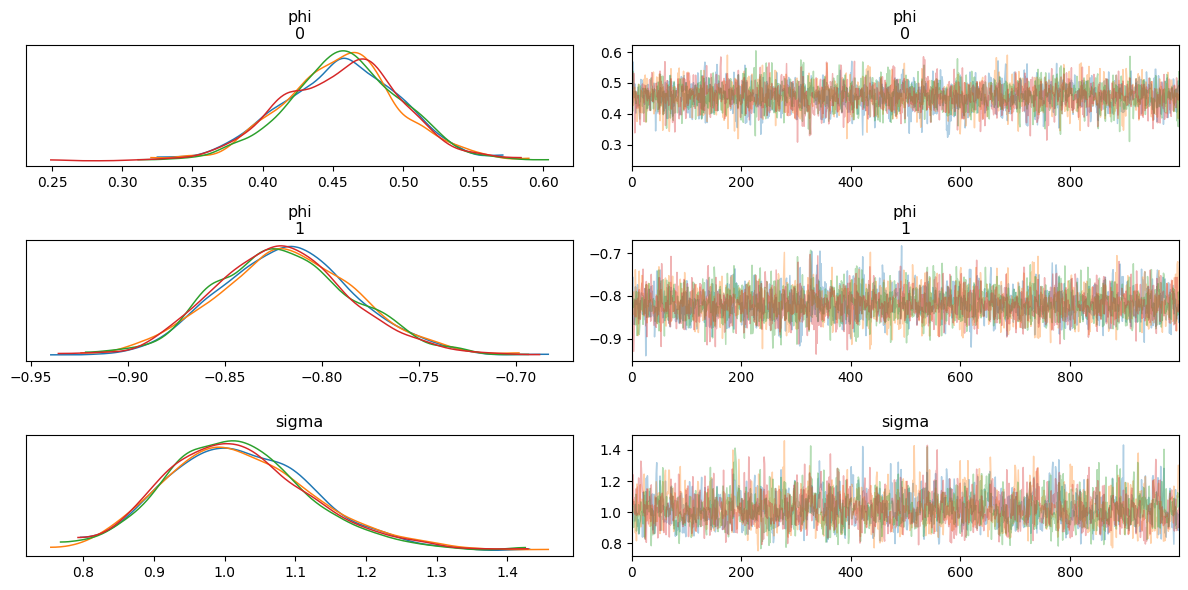

In [50]:
az.plot_trace(ts_miss_az, var_names=["phi", "sigma"], compact=False)
plt.tight_layout()
plt.show()

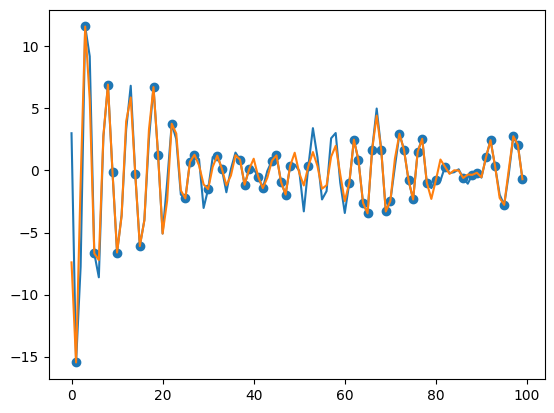

In [51]:
plt.plot(y_true)
plt.scatter(obs_idx, y_obs)

med_y = np.vstack(ts_miss_az.posterior.y.to_numpy())
med_y = np.median(med_y, axis=0)

plt.plot(med_y)